In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from functions.datacleaning import MoscowHousing as mh

In [2]:
# Get data
data = mh(
          coordinates=None,
          data_train="../prepared_data/train_prepared.csv",
          data_test="../prepared_data/test_prepared.csv",
          # test_prepared.csv is already complete
          need_correction=False,
          # Base float values are already normalized with 0 as mean
          normalize = False,
          # Passing floats (not really necessary)
          features_float = ["area_total", 
                            "distance", 
                            "area_kitchen", 
                            "area_living", 
                            "ceiling",
                            "distance_metro"]
        )

XTrain, YTrain = data.get_data_train()

In [69]:
# Features to remove in both training and test data
features_remove_train = ["id", "building_id", "layout",
                         "seller", "condition", 
                         "loggias", "countpattern_street",
                         "material", "price_per_square_meter",
                         "elevator_without", "ceiling",
                         "elevator_passenger", "elevator_service", "parking", 
                         "garbage_chute", "heating", "latitude", "longitude", 
                         "street", "address", "phones", "new"]

"""features_remove_train = ["area_kitchen", "area_living", "layout",
                         "seller", "condition", "stories", "distance",
                         "windows_court", "windows_street", "distance_metro",
                         "bathrooms_shared", "bathrooms_private",
                         "balconies", "loggias", "countpattern_street",
                         "material", "ceiling", "area_total", "price_per_square_meter",
                         "elevator_without", "floor", "rooms", "district",
                         "elevator_passenger", "elevator_service", "parking", 
                         "garbage_chute", "heating", "latitude", "longitude", 
                         "street", "address", "phones"]"""

# First prep - remove unwanted features
X_Train = XTrain.drop(features_remove_train, axis=1)

In [70]:
print("number of nans in bathrooms_private", len(X_Train.loc[X_Train["bathrooms_private"].isnull()].index)) # 26
print("number of nans in bathrooms_shared", len(X_Train.loc[X_Train["bathrooms_shared"].isnull()].index))

number of nans in bathrooms_private 3872
number of nans in bathrooms_shared 3872


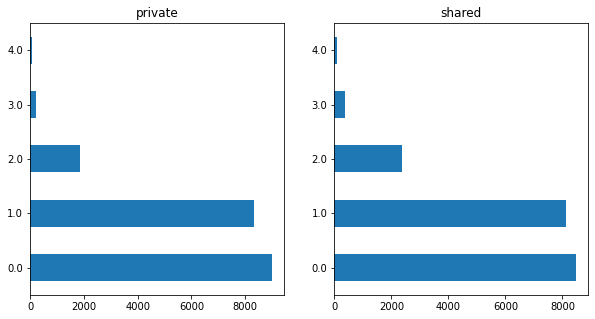

In [71]:

# if one is null, then both is null
len(X_Train.loc[(X_Train["bathrooms_private"].isnull()) & (X_Train["bathrooms_shared"].notnull())]) # 0
len(X_Train.loc[(X_Train["bathrooms_shared"].isnull()) & (X_Train["bathrooms_private"].notnull())]) # 0

len(X_Train.loc[(X_Train["bathrooms_shared"] == 0) & (X_Train["bathrooms_private"] > 0)]) # =0: 8478, =1: 1540, =2: 367, =3: 23, =4: 23
len(X_Train.loc[(X_Train["bathrooms_private"] == 0) & (X_Train["bathrooms_shared"] > 0)]) # =0: 8982, =1: 1761, =2: 174, =3: 13, =4: 5

# 
len(X_Train.loc[X_Train["bathrooms_private"] == 4]) # 60
len(X_Train.loc[X_Train["bathrooms_shared"] == 4]) # 102

fig, axes = plt.subplots(ncols=2)
X_Train["bathrooms_private"].value_counts().sort_index(ascending=True).plot(kind='barh', figsize=(10,5), ax=axes[0], title="private")
X_Train["bathrooms_shared"].value_counts().sort_index(ascending=True).plot(kind='barh', figsize=(10,5), ax=axes[1], title="shared")
plt.show()


1
Test MSLE: 0.04


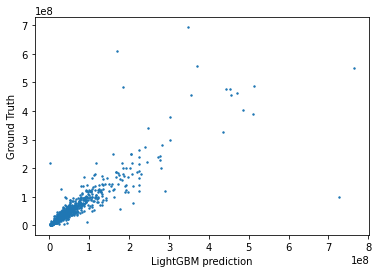

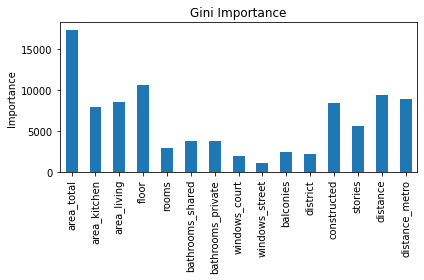

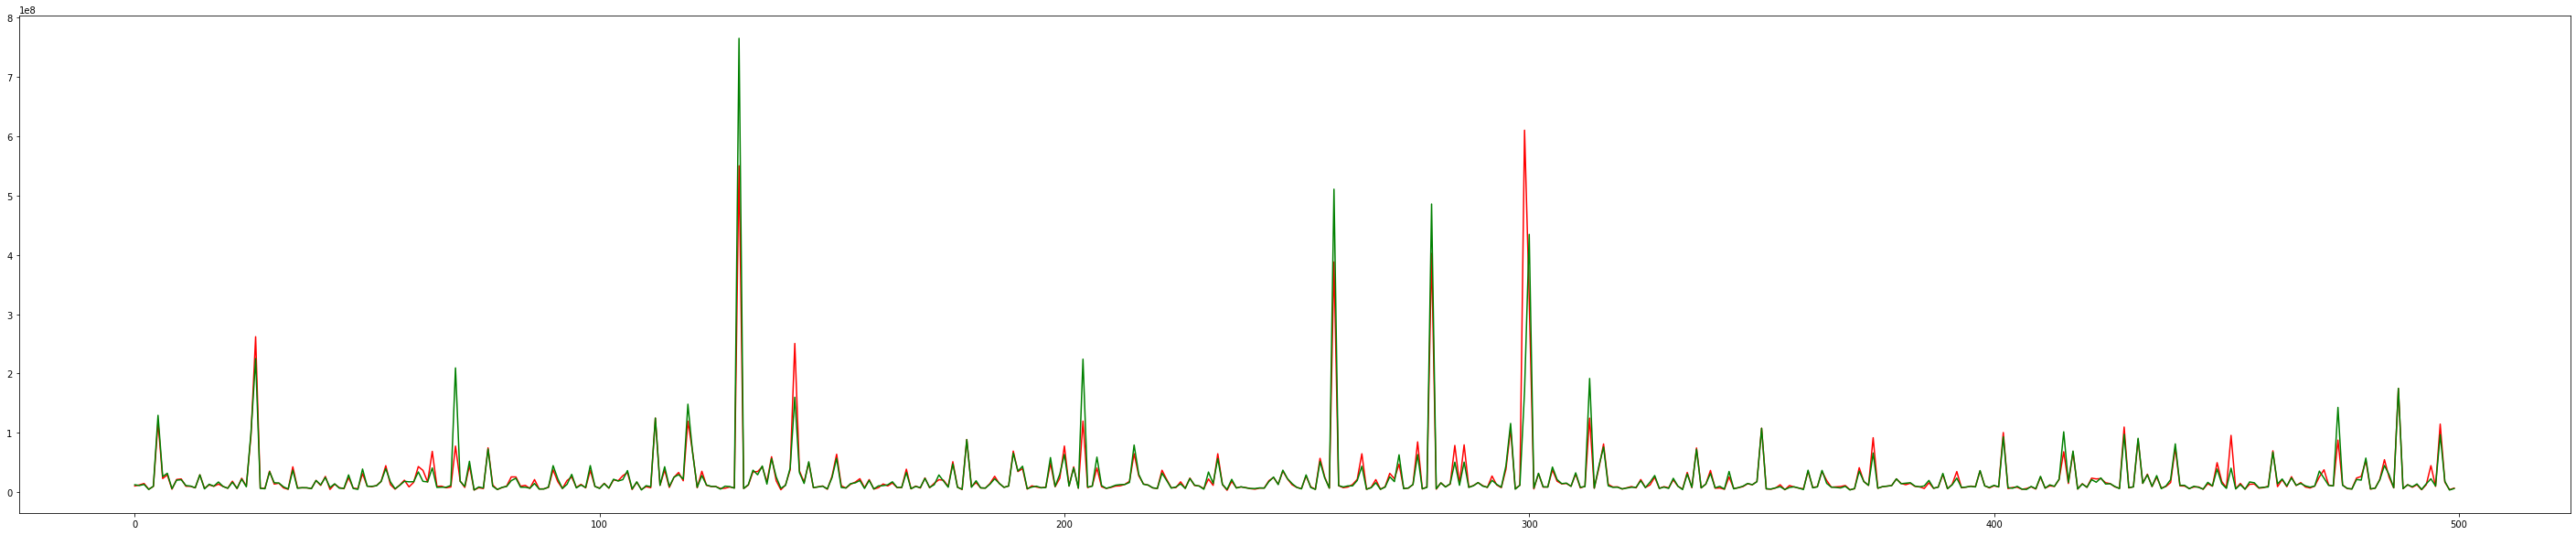

In [72]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error

def predict_and_analyze(dataset):
    # split training data into test and training split
    X_train1, X_test1 = train_test_split(dataset, test_size=0.15, random_state=42)

    # remove apartments with very high price from training-test data
    # qhigh = X_train1["price"].quantile(0.99)
    # X_train1 = X_train1[(X_train1["price"] < qhigh)]

    # get price columns 
    y_train = X_train1.pop("price")
    y_test = X_test1.pop("price")

    model5 = lgb.LGBMRegressor(
        num_leaves=100,
        max_depth=10, 
        random_state=42,
        metric='msle',
        n_jobs=4, 
        n_estimators=3000,
        colsample_bytree=0.95,
        subsample=0.9,
        learning_rate=0.05
    )

    model5.fit(X_train1, y_train)

    lgbm_prediction = model5.predict(X_test1)

    faulty_rows = []
    for i in range(len(lgbm_prediction)):
        if lgbm_prediction[i] < 900000:
            lgbm_prediction[i] = 900000
            faulty_rows.append(i)

    # list apartments resulting in too low price
    print(len(faulty_rows))

    lgb_msle = round(mean_squared_log_error(lgbm_prediction, y_test), 2)
    print('Test MSLE:', lgb_msle)

    # correct predictions are on the diagonal
    plt.scatter(lgbm_prediction, y_test, s=2)
    plt.xlabel('LightGBM prediction')
    plt.ylabel('Ground Truth')
    plt.show()

    # important features
    importances = model5.feature_importances_
    forest_importances = pd.Series(importances, index=X_train1.columns)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Gini Importance")
    ax.set_ylabel("Importance")
    fig.tight_layout()

    # red is real prices, green is predicted prices
    plt.figure(figsize=(50, 10))
    plt.plot(y_test.values[:500], color = 'red')
    plt.plot(lgbm_prediction[:500], color = 'green')
    plt.show()
    

predict_and_analyze(X_Train)

Tried to combine bathrooms into one column, but it leads to fairly significant drops in performance.
num_bathrooms = num_private-num_shared was the most promising, but had MSLE of 0.68 compared to 0.59 when only using those two columns.
When running combined bathrooms column with a selection of other features it did not perform that much worse (0.04 to 0.05 MSLE), but 0.01 is not insignificant when using so many other features.
The importance analysis says that the column is one of the most important for predicting. 

When running simplified columns (boolean) with other features the performance is the same, but the importance of the columns are much lower so they didn't impact the prediction much.

Can one hot encode both if necessary, it will lead to 12 columns instead of 2. Not sure if this is too much.

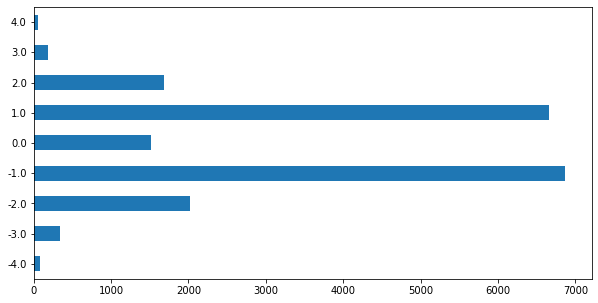

3
Test MSLE: 0.05


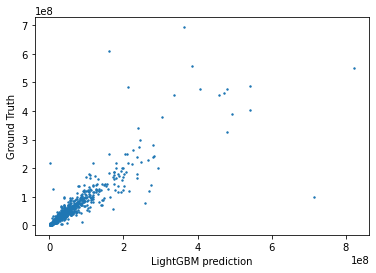

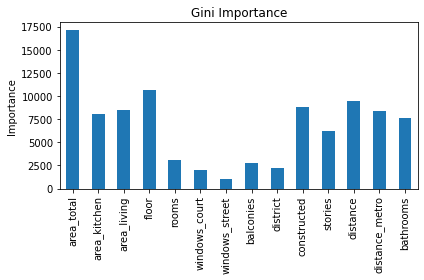

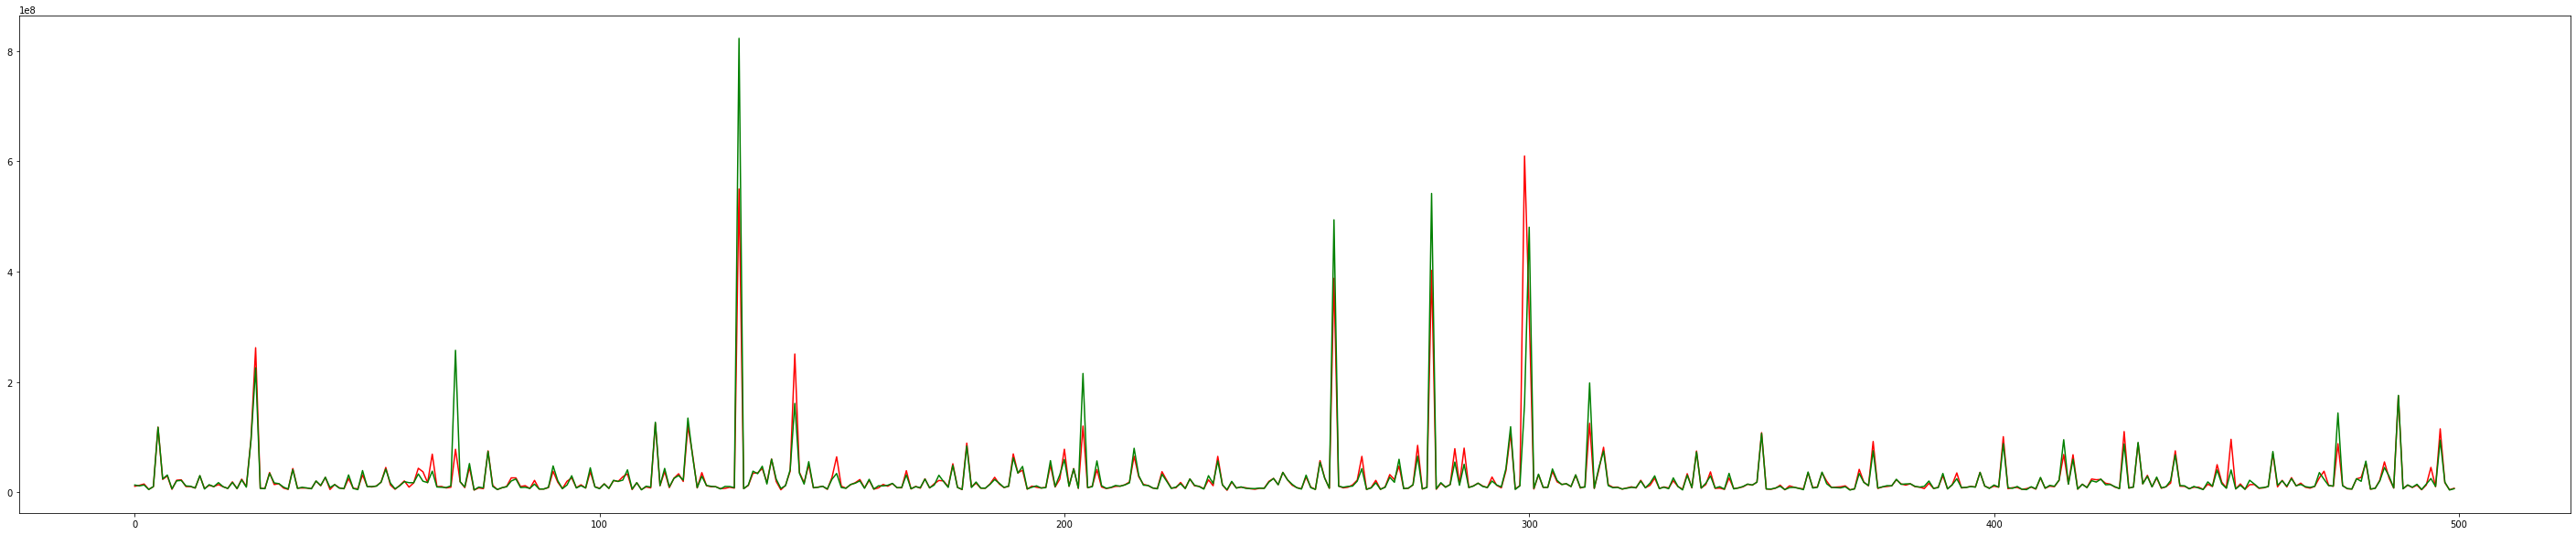

In [74]:
X_Train2 = X_Train.copy()

# combine columns
X_Train2["bathrooms"] = X_Train2["bathrooms_private"] + (X_Train2["bathrooms_shared"]*0.5)  # MSLE = 0.75
X_Train2["bathrooms"] = X_Train2["bathrooms_private"] - X_Train2["bathrooms_shared"]        # MSLE = 0.68
# plot
X_Train2["bathrooms"].value_counts().sort_index(ascending=True).plot(kind = 'barh', figsize=(10,5))
plt.show()

# simplify columns by converting to boolean
""" X_Train2["has_bathrooms_private"] = (X_Train2["bathrooms_private"] > 0)
X_Train2["has_bathrooms_shared"] = (X_Train2["bathrooms_shared"] > 0)
 """
# one hot encode
""" def hot_encode(x, hot):
    for h in hot:
        df = pd.get_dummies(x[h], prefix=h, dummy_na=True)
        x = pd.concat([x, df], axis=1) 
    return x

hot_list = ["bathrooms_private", "bathrooms_shared"]
X1 = hot_encode(X_Train2[hot_list], hot_list)
X_Train2 = pd.concat([X_Train2, X1], axis=1) """

# remove columns
X_Train2.pop("bathrooms_private")
X_Train2.pop("bathrooms_shared")

predict_and_analyze(X_Train2)